In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyriemann.datasets.simulated import make_classification_transfer
from pyriemann.embedding import SpectralEmbedding
from pyriemann.transfer import decode_domains, TLCenter, TLRotate

In [2]:
# Fix seed for reproducible results
seed = 66

# create source and target datasets
n_matrices = 50
X_enc, y_enc = make_classification_transfer(
    n_matrices=n_matrices,
    class_sep=2.0,
    class_disp=0.25,
    domain_sep=2.0,
    theta=np.pi/4,
    random_state=seed
)

# generate dataset
X_org, y, domain = decode_domains(X_enc, y_enc)

# instantiate object for doing spectral embeddings
emb = SpectralEmbedding(n_components=2, metric="riemann")

# create dict to store the embedding after each step of RPA
embedded_points = {}

# embed the original source and target datasets
points = np.concatenate([X_org, np.eye(2)[None, :, :]])  # stack the identity
embedded_points["origin"] = emb.fit_transform(points)

# embed the source and target datasets after recentering
rct = TLCenter(target_domain="target_domain")
X_rct = rct.fit_transform(X_org, y_enc)
points = np.concatenate([X_rct, np.eye(2)[None, :, :]])  # stack the identity
embedded_points["rct"] = emb.fit_transform(points)

# embed the source and target datasets after recentering
rot = TLRotate(target_domain="target_domain", metric="riemann")
X_rot = rot.fit_transform(X_rct, y_enc)

points = np.concatenate([X_org, X_rct, X_rot, np.eye(2)[None, :, :]])
S = emb.fit_transform(points)
S = S - S[-1]
embedded_points["origin"] = S[:4*n_matrices]
embedded_points["rct"] = S[4*n_matrices:8*n_matrices]
embedded_points["rot"] = S[8*n_matrices:-1]

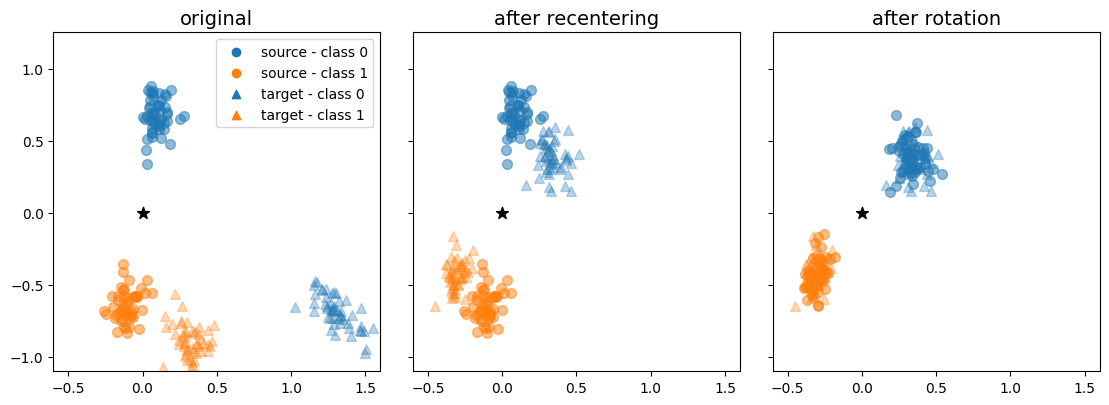

In [3]:
fig, ax = plt.subplots(figsize=(13.5, 4.4), ncols=3, sharey=True)
plt.subplots_adjust(wspace=0.10)
steps = ["origin", "rct", "rot"]
titles = ["original", "after recentering", "after rotation"]
for axi, step, title in zip(ax, steps, titles):
    S_step = embedded_points[step]
    S_source = S_step[domain == "source_domain"]
    y_source = y[domain == "source_domain"]
    S_target = S_step[domain == "target_domain"]
    y_target = y[domain == "target_domain"]
    axi.scatter(
        S_source[y_source == "1"][:, 0],
        S_source[y_source == "1"][:, 1],
        c="C0", s=50, alpha=0.50,
    )
    axi.scatter(
        S_source[y_source == "2"][:, 0],
        S_source[y_source == "2"][:, 1],
        c="C1", s=50, alpha=0.50,
    )
    axi.scatter(
        S_target[y_target == "1"][:, 0],
        S_target[y_target == "1"][:, 1],
        c="C0", s=50, alpha=0.30, marker="^",
    )
    axi.scatter(
        S_target[y_target == "2"][:, 0],
        S_target[y_target == "2"][:, 1],
        c="C1", s=50, alpha=0.30, marker="^",
    )
    axi.scatter(S[-1, 0], S[-1, 1], c="k", s=80, marker="*")
    axi.set_xlim(-0.60, +1.60)
    axi.set_ylim(-1.10, +1.25)
    axi.set_xticks([-0.5, 0.0, 0.5, 1.0, 1.5])
    axi.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    axi.set_title(title, fontsize=14)
ax[0].scatter([], [], c="C0", label="source - class 0")
ax[0].scatter([], [], c="C1", label="source - class 1")
ax[0].scatter([], [], marker="^", c="C0", label="target - class 0")
ax[0].scatter([], [], marker="^", c="C1", label="target - class 1")
ax[0].legend(loc="upper right")
plt.show()